<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Text2Image_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install diffusers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.8 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionPipeline

# Load the Stable Diffusion model from Hugging Face
model_id = "CompVis/stable-diffusion-v1-4"  # Model ID from Hugging Face Model Hub
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")  # Move the model to GPU for faster inference

# Define a text prompt for image generation
prompt = "A futuristic cityscape with flying cars and neon lights"

# Generate the image conditioned on the text prompt
with torch.autocast("cuda"):
    image = pipe(prompt).images[0]

# Save the generated image
image.save("generated_image.png")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-11-55411dfb2c45>:52: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/100 [00:00<?, ?it/s]

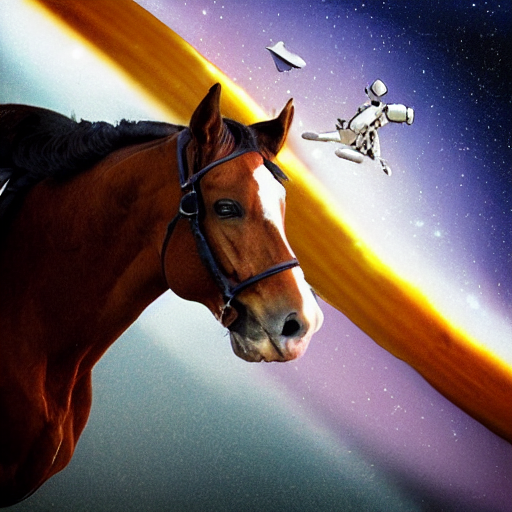

In [11]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler
from PIL import Image

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")



scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100           # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(0)    # Seed generator to create the inital latent noise

batch_size = len(prompt)


text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample


image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]



In [7]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler
from PIL import Image
import numpy as np

# Step 1: Load the tokenizer and text encoder (CLIP model)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")

# Step 2: Load the UNet model (diffusion model)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to("cuda")

# Step 3: Load the VAE (Variational Autoencoder) to decode latent representations into images
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda")

# Step 4: Load the scheduler (used to reverse the noise process)
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# Step 5: Define the text prompt
prompt = "A futuristic cityscape with flying cars and neon lights"

# Step 6: Tokenize the input text and encode it to get text embeddings
text_input = tokenizer(prompt, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]  # [batch_size, seq_len, hidden_size]

# Step 7: Prepare the scheduler with the number of denoising steps
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps)

# Step 8: Sample random noise in the latent space to start the reverse diffusion process
# NOTE: Ensure the latent tensor shape matches the VAE expected input (latent_shape: [1, 4, 64, 64])
latents = torch.randn((1, unet.in_channels, 64, 64)).to("cuda")  # Latent shape: [batch_size, channels, height, width]

# Step 9: Perform the reverse diffusion process
latents = latents * scheduler.init_noise_sigma  # Scale the initial noise
for t in scheduler.timesteps:
    # Prepare the input by concatenating latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)  # Duplicate latents for guidance

    # Ensure text embeddings match the batch size and are broadcasted appropriately
    batch_size, _, h, w = latent_model_input.shape

    # First ensure text embeddings are in 3D: [batch_size, seq_len, hidden_size]
    # Then repeat them across the spatial dimensions
    text_embeddings_broadcasted = text_embeddings.repeat(1, h * w, 1)

    # Predict the noise residual with UNet
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings_broadcasted).sample

    # Perform classifier-free guidance (separate conditional and unconditional outputs)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guidance_scale = 7.5
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Update latents using the scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Step 10: Decode the latent representation using the VAE to get the image
# Scale latents before decoding as per Stable Diffusion's latent space requirements
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Step 11: Convert the image to a format suitable for visualization (from tensor to PIL image)
image = (image / 2 + 0.5).clamp(0, 1)  # Normalize the image to [0, 1]
image = image.cpu().permute(0, 2, 3, 1).numpy()  # Rearrange dimensions
image = (image * 255).round().astype("uint8")  # Convert to uint8 format
image = Image.fromarray(image[0])

# Step 12: Save the generated image
image.save("generated_image_fixed.png")


<ipython-input-7-5a0fe75dc5e1>:33: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 64, 64)).to("cuda")  # Latent shape: [batch_size, channels, height, width]


RuntimeError: The size of tensor a (8192) must match the size of tensor b (4096) at non-singleton dimension 1

In [6]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the individual components of the Stable Diffusion pipeline

# Load the autoencoder model for encoding and decoding images
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", torch_dtype=torch.float16)
vae = vae.to("cuda")

# Load the U-Net model for the diffusion process
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet", torch_dtype=torch.float16)
unet = unet.to("cuda")

# Load the scheduler to manage the denoising process
scheduler = PNDMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

# 2. Define your text prompt and generate the text embeddings
prompt = "A photorealistic image of a cat wearing a top hat, sitting on a park bench."

# Load the tokenizer and text encoder to process the prompt
from transformers import CLIPTokenizer, CLIPTextModel
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = text_encoder.to("cuda")

# Tokenize the prompt
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")

# Encode the text
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]

# 3. Generate a latent representation (noise)
latents = torch.randn(
  (1, unet.in_channels, 64, 64),
  generator=torch.manual_seed(0),  # You can change the seed for different results
)
latents = latents.to("cuda")

# 4. Denoising loop
scheduler.set_timesteps(50)  # Adjust the number of denoising steps
for t in scheduler.timesteps:
  # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)
  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual
  with torch.no_grad():
    # *** Convert t to float16 and text_embeddings to float32 ***
    noise_pred = unet(latent_model_input, t.to(torch.float16), encoder_hidden_states=text_embeddings.to(torch.float32)).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)  # Adjust guidance scale (7.5 here)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

# 5. Decode the latents into an image
latents = 1 / 0.18215 * latents  # Scale the latents
with torch.no_grad():
  image = vae.decode(latents).sample

# 6. Process the image
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")

# 7. Display or save the image
from PIL import Image
image = Image.fromarray(image[0])
image.save("cat_with_top_hat.png")

<ipython-input-6-a3a498f2b693>:35: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, unet.in_channels, 64, 64),


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Half